# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'traffic_signs_data/train.p'
testing_file = 'traffic_signs_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
n_train = len(X_train)

n_test = len(X_test)

image_shape = X_train.shape[1:]

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

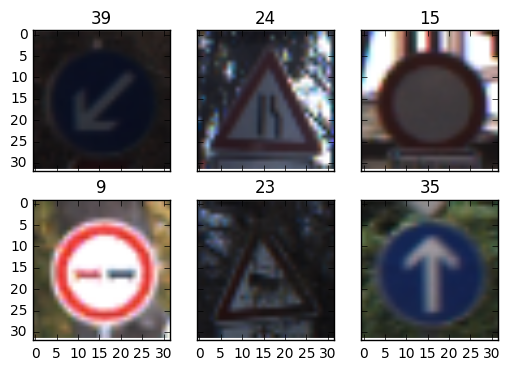

In [4]:
import random
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row')

# Randomly select 6 different categories
categories = random.sample(range(n_classes), 6)

# Randomly select 1 image each from the 6 categories and display
image_1 = random.choice([i for i in range(len(y_train)) if y_train[i] == categories[0]])
ax1.imshow(X_train[image_1,:,:,:])
ax1.set_title(categories[0])
image_2 = random.choice([i for i in range(len(y_train)) if y_train[i] == categories[1]])
ax2.imshow(X_train[image_2,:,:,:])
ax2.set_title(categories[1])
image_3 = random.choice([i for i in range(len(y_train)) if y_train[i] == categories[2]])
ax3.imshow(X_train[image_3,:,:,:])
ax3.set_title(categories[2])
image_4 = random.choice([i for i in range(len(y_train)) if y_train[i] == categories[3]])
ax4.imshow(X_train[image_4,:,:,:])
ax4.set_title(categories[3])
image_5 = random.choice([i for i in range(len(y_train)) if y_train[i] == categories[4]])
ax5.imshow(X_train[image_5,:,:,:])
ax5.set_title(categories[4])
image_6 = random.choice([i for i in range(len(y_train)) if y_train[i] == categories[5]])
ax6.imshow(X_train[image_6,:,:,:])
ax6.set_title(categories[5])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
import numpy as np
import cv2

# Source: https://nbviewer.jupyter.org/github/vxy10/SCND_notebooks/blob/master/preprocessing_stuff/img_transform_NB.ipynb
def transform_image(img, ang_range, shear_range, trans_range):
    # Rotation
    ang_rot = np.random.uniform(ang_range) - ang_range/2
    rows,cols,ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2), ang_rot, 1)
    
    # Translation
    tr_x = trans_range*np.random.uniform() - trans_range/2
    tr_y = trans_range*np.random.uniform() - trans_range/2
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    
    # Shear
    pts1 = np.float32([[5,5], [20,5], [5,20]])
    pt1 = 5 + shear_range*np.random.uniform() - shear_range/2
    pt2 = 20 + shear_range*np.random.uniform() - shear_range/2
    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])
    shear_M = cv2.getAffineTransform(pts1, pts2)
    
    img = cv2.warpAffine(img, Rot_M, (cols, rows))
    img = cv2.warpAffine(img, Trans_M, (cols, rows))
    img = cv2.warpAffine(img, shear_M, (cols, rows))
    
    return img

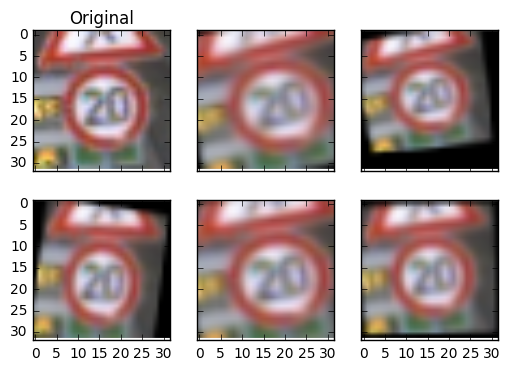

In [6]:
# Display transformed images
test_image = X_train[6, :, :]

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row')
ax1.imshow(test_image)
ax1.set_title('Original')
ax2.imshow(transform_image(test_image, 10, 5, 1))
ax3.imshow(transform_image(test_image, 10, 5, 1))
ax4.imshow(transform_image(test_image, 10, 5, 1))
ax5.imshow(transform_image(test_image, 10, 5, 1))
ax6.imshow(transform_image(test_image, 10, 5, 1))

In [7]:
# Histogram equzliation
def preprocess_image(X_train):
    result = []
    image_shape = X_train.shape[1:]
    # For each images
    for i in range(len(X_train)):
        image = X_train[i].reshape((image_shape[0]*image_shape[1], image_shape[2]))
        image = cv2.equalizeHist(image)
        result.append(image.reshape(image_shape))
    return np.array(result) / 255 - 0.5

In [8]:
from sklearn.utils import shuffle

# Apply histogram equalization on each image
X_train = preprocess_image(X_train)
X_test = preprocess_image(X_test)

from sklearn.model_selection import train_test_split
# Split data to have training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [9]:
# Generate additional data
def generate_data(X_train, y_train, ang_range=20, shear_range=10, trans_range=5, num_data=5):
    X_train_res = []
    y_train_res = []
    for i in range(len(X_train)):
        for _ in range(num_data):
            X_train_res.append(transform_image(X_train[i], ang_range, shear_range, trans_range))
            y_train_res.append(y_train[i])
    return np.array(X_train_res), np.array(y_train_res)

# LeNet

In [10]:
import tensorflow as tf

In [11]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    
    # Layer 1: Convolutional.
    # Input = 32x32x3. Ouput = 28x28x6.
    conv1_W = tf.get_variable("conv1_W", shape=(5, 5, 3, 6), initializer=tf.contrib.layers.xavier_initializer())
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling.
    # Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional.
    # Input = 14x14x6. Output = 10x10x16.
    conv2_W = tf.get_variable("conv2_W", shape=(5, 5, 6, 16), initializer=tf.contrib.layers.xavier_initializer())
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling.
    # Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten.
    # Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected.
    # Input = 400. Output = 120.
    fc1_W = tf.get_variable("fc1_W", shape=(400, 120), initializer=tf.contrib.layers.xavier_initializer())
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected.
    # Input = 120. Output = 84.
    fc2_W  = tf.get_variable("fc2_W", shape=(120, 84), initializer=tf.contrib.layers.xavier_initializer())
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected.
    # Input = 84. Output = 43.
    fc3_W  = tf.get_variable("fc3_W", shape=(84, 43), initializer=tf.contrib.layers.xavier_initializer())
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

EPOCHS = 10
BATCH_SIZE = 128

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #num_examples = len(X_train)
    
    print("Training...")
    print()
    ang_range = 10
    shear_range = 5
    trans_range = 1
    for i in range(EPOCHS):
        #X_train, y_train = shuffle(X_train, y_train)
        X_train_new, y_train_new = generate_data(X_train, y_train, ang_range, shear_range, trans_range, 4)
        X_train_new, y_train_new = shuffle(X_train_new, y_train_new)
        #ang_range *= 0.9
        #shear_range *= 0.9
        #trans_range *= 0.9
        for offset in range(0, len(X_train_new), BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_new[offset:end], y_train_new[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_val, y_val)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.892

EPOCH 2 ...
Validation Accuracy = 0.956

EPOCH 3 ...
Validation Accuracy = 0.971

EPOCH 4 ...
Validation Accuracy = 0.977

EPOCH 5 ...
Validation Accuracy = 0.978

EPOCH 6 ...
Validation Accuracy = 0.979

EPOCH 7 ...
Validation Accuracy = 0.983

EPOCH 8 ...
Validation Accuracy = 0.984

EPOCH 9 ...
Validation Accuracy = 0.987

EPOCH 10 ...
Validation Accuracy = 0.986

Model saved


In [14]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.930


# VGG16 Net

In [10]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def VGG_16_simp(x):    
    
    # Layer 1: Convolutional.
    # Input = 32x32x3. Output = 32x32x64.
    conv1_W = tf.get_variable("conv1_W", shape=(3, 3, 3, 64), initializer=tf.contrib.layers.xavier_initializer())
    conv1_b = tf.Variable(tf.zeros(64))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling.
    # Input = 32x32x64. Output = 16x16x64.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional.
    # Input = 16x16x64. Output = 16x16x128.
    conv2_W = tf.get_variable("conv2_W", shape=(3, 3, 64, 128), initializer=tf.contrib.layers.xavier_initializer())
    conv2_b = tf.Variable(tf.zeros(128))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling.
    # Input = 16x16x128. Output = 8x8x128.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten.
    # Input = 8x8x128. Output = 8192.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected.
    # Input = 8192. Output = 4096.
    fc1_W = tf.get_variable("fc1_W", shape=(8192, 4096), initializer=tf.contrib.layers.xavier_initializer())
    fc1_b = tf.Variable(tf.zeros(4096))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected.
    # Input = 4096. Output = 4096.
    fc2_W = tf.get_variable("fc2_W", shape=(4096, 4096), initializer=tf.contrib.layers.xavier_initializer())
    fc2_b  = tf.Variable(tf.zeros(4096))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected.
    # Input = 4096. Output = 43.
    fc3_W = tf.get_variable("fc3_W", shape=(4096, 43), initializer=tf.contrib.layers.xavier_initializer())
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [11]:
import tensorflow as tf

In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = VGG_16_simp(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

EPOCHS = 10
BATCH_SIZE = 128

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    ang_range = 10
    shear_range = 5
    trans_range = 1
    for i in range(EPOCHS):
        #X_train, y_train = shuffle(X_train, y_train)
        X_train_new, y_train_new = generate_data(X_train, y_train, ang_range, shear_range, trans_range, 4)
        X_train_new, y_train_new = shuffle(X_train_new, y_train_new)
        for offset in range(0, len(X_train_new), BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_new[offset:end], y_train_new[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_val, y_val)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'vggnet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.988

EPOCH 2 ...
Validation Accuracy = 0.989

EPOCH 3 ...
Validation Accuracy = 0.989

EPOCH 4 ...
Validation Accuracy = 0.996

EPOCH 5 ...
Validation Accuracy = 0.994

EPOCH 6 ...
Validation Accuracy = 0.990

EPOCH 7 ...
Validation Accuracy = 0.991

EPOCH 8 ...
Validation Accuracy = 0.996

EPOCH 9 ...
Validation Accuracy = 0.993

EPOCH 10 ...
Validation Accuracy = 0.997

Model saved


In [14]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('vggnet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.953


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I preprocessed the data by using histogram equalization and then recale all images intensity to values between -0.5 to 0.5. Histogram equalization will take away the effect of brightness variation and zero-centering the image will allow easier optimization.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

First, i split the given training data into training and validation set (70% training, 30% validation). For each training example, 4 data are being generated by randomly rotating, shearing, and translating it.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The input is being zero-padded before every convolutional layers.
Types of model: Adaptation of VGGNet
Layers:
    - Layer 1 (Convolutional)
        - Input = 32x32x3. Output = 32x32x64.
        - 64 filters (3x3)
        - ReLu activation
    - Maxpooling
        - Input = 32x32x64. Output = 16x16x64.
        - 2x2 filter (stride of 2)
    - Layer 2 (Convolutional)
        - Input = 16x16x64. Output = 16x16x128.
        - 128 filters (3x3)
        - ReLu activation
    - Maxpooling
        - Input = 16x16x128. Output = 8x8x128.
        - 2x2 filter (stride of 2)
    - Flatten
        - Input = 8x8x128. Output = 8192.
    - Layer 3 (Fully Connected)
        - Input = 8192. Output = 4096.
        - 4096 neurons
        - ReLu activation
    - Layer 4 (Fully Connected)
        - Input = 4096. Output = 4096.
        - 4096 neurons
        - ReLu activation
    - Layer 5 (Fully Connected)
        - Input = 4096. Output = 43.
        - 43 neurons (logits)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used adam for optimizer (0.9 for exponential decay rate for the 1st moment estimates, 0.999 for exponential decay rate for the 2nd moment estimates), 128 as batch size and 10 epochs. The learning rate for the adam optimizer is 0.001.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I used the LeNet architecture on the original data as a benchmark and try differnt data preprocessing and data generation techniques to improve the accuracy. I then try to improve the accuracy by using an architecture that is an adaptation of the VGGNet. I have also tried applying dropout but got poorer performance.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [16]:
import glob
from scipy.misc import imresize

In [17]:
image_list = []
for img in glob.glob("test_image/image_*.jpg"):
    image_list.append(imresize(plt.imread(img), (32, 32)))
image_list = np.asarray(image_list)

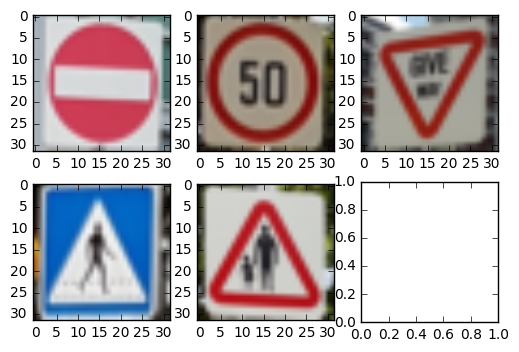

In [19]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

ax1.imshow(image_list[0])
ax2.imshow(image_list[1])
ax3.imshow(image_list[2])
ax4.imshow(image_list[3])
ax5.imshow(image_list[4])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

For all the traffic signs above, only the 1st and 2nd images has category in the training data set. So the model will not be able to classify the 3rd, 4th, and 5th images correctly. Factors that might make classification difficult includes brightness of the image, contrast of the image, angle of the traffic sign in the image, pixel jittering in the image, foreign traffic signs, and background objects in the image.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [21]:
import copy
# Make a copy of the image to compare later
image_list_ori = copy.copy(image_list)
image_list = preprocess_image(image_list)

In [22]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    logits_res = sess.run(logits, feed_dict={x: image_list})

In [23]:
logits_exp = np.exp(logits_res)
rows = np.sum(logits_exp, axis=1)
probs = logits_exp / rows[:, None]

In [25]:
categories = np.argmax(probs, axis=1)

Display images from training dataset that correspond with the predicted label for own test data.

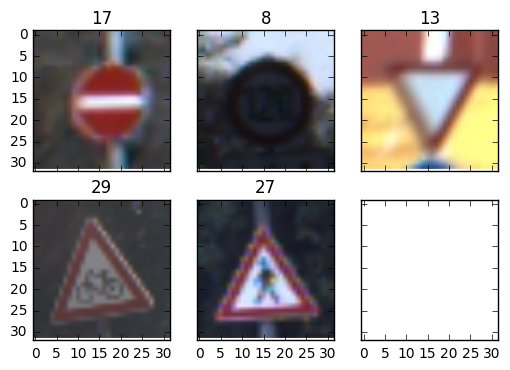

In [31]:
X_train2, y_train2 = train['features'], train['labels']

import random
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row')

# Randomly select 1 image each from the 8 categories and display
image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == categories[0]])
ax1.imshow(X_train2[image_1,:,:,:])
ax1.set_title(categories[0])
image_2 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == categories[1]])
ax2.imshow(X_train2[image_2,:,:,:])
ax2.set_title(categories[1])
image_3 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == categories[2]])
ax3.imshow(X_train2[image_3,:,:,:])
ax3.set_title(categories[2])
image_4 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == categories[3]])
ax4.imshow(X_train2[image_4,:,:,:])
ax4.set_title(categories[3])
image_5 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == categories[4]])
ax5.imshow(X_train2[image_5,:,:,:])
ax5.set_title(categories[4])

The model is able to predict 1 out of 5 signs correctly, it's 20% accurate.

From the prediction i did to the 5 traffic sign images, only 1 out of 5 images are classified correctly, the testing accuracy is 20%. However, the 3rd, 4th, and 5th images does not have a category in the training dataset.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [32]:
with tf.Session() as sess:
    top_5 = sess.run(tf.nn.top_k(tf.constant(logits_res), k=5))

In [33]:
top_5

TopKV2(values=array([[  3.04421854,   2.4875524 ,   1.77035248,   1.61235511,
          0.22260785],
       [  3.19042492,   2.08219624,   1.07498693,   0.55134672,  -0.5175094 ],
       [ 21.01105309,   0.13122225,  -0.73610157,  -0.86551422,
         -1.28250587],
       [  9.279356  ,   6.27428865,   4.11169863,  -6.21996689,
         -6.78688622],
       [ 11.52645397,  10.45740414,   3.89298916,  -2.045784  ,
         -4.54569006]], dtype=float32), indices=array([[17,  9,  1,  8, 14],
       [ 8,  2,  9,  5,  7],
       [13, 14,  7,  1,  5],
       [29, 18, 27, 36, 12],
       [27, 18, 24,  1, 28]], dtype=int32))

Display original image and the 5 images of the categories that are predicted for the image.

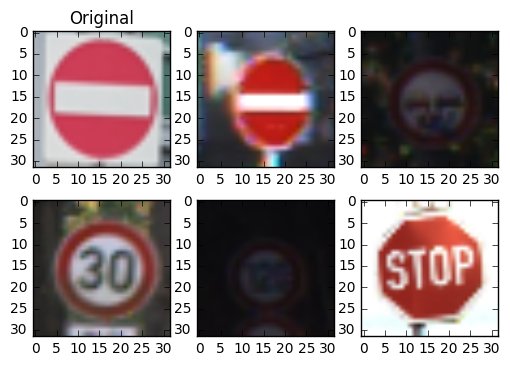

In [36]:
image_index = 0
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

ax1.imshow(image_list_ori[image_index])
ax1.set_title('Original')

image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][0]])
ax2.imshow(X_train2[image_1,:,:,:])
image_2 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][1]])
ax3.imshow(X_train2[image_2,:,:,:])
image_3 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][2]])
ax4.imshow(X_train2[image_3,:,:,:])
image_4 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][3]])
ax5.imshow(X_train2[image_4,:,:,:])
image_5 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][4]])
ax6.imshow(X_train2[image_5,:,:,:])

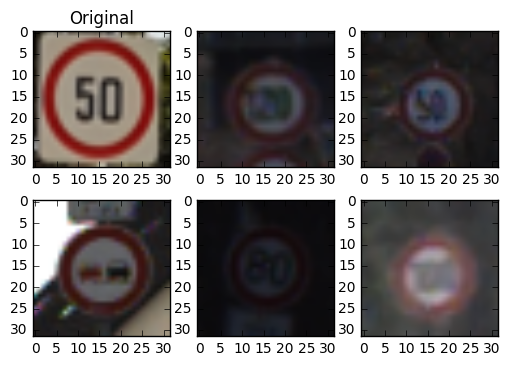

In [37]:
image_index = 1
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

ax1.imshow(image_list_ori[image_index])
ax1.set_title('Original')

image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][0]])
ax2.imshow(X_train2[image_1,:,:,:])
image_2 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][1]])
ax3.imshow(X_train2[image_2,:,:,:])
image_3 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][2]])
ax4.imshow(X_train2[image_3,:,:,:])
image_4 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][3]])
ax5.imshow(X_train2[image_4,:,:,:])
image_5 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][4]])
ax6.imshow(X_train2[image_5,:,:,:])

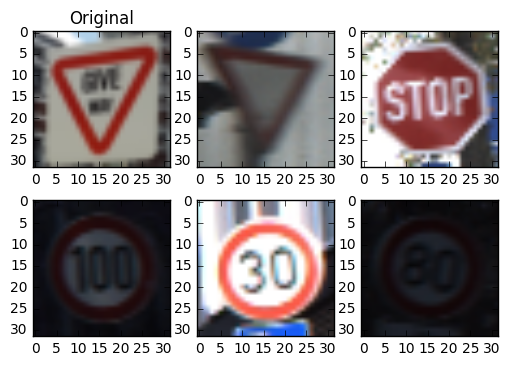

In [38]:
image_index = 2
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

ax1.imshow(image_list_ori[image_index])
ax1.set_title('Original')

image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][0]])
ax2.imshow(X_train2[image_1,:,:,:])
image_2 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][1]])
ax3.imshow(X_train2[image_2,:,:,:])
image_3 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][2]])
ax4.imshow(X_train2[image_3,:,:,:])
image_4 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][3]])
ax5.imshow(X_train2[image_4,:,:,:])
image_5 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][4]])
ax6.imshow(X_train2[image_5,:,:,:])

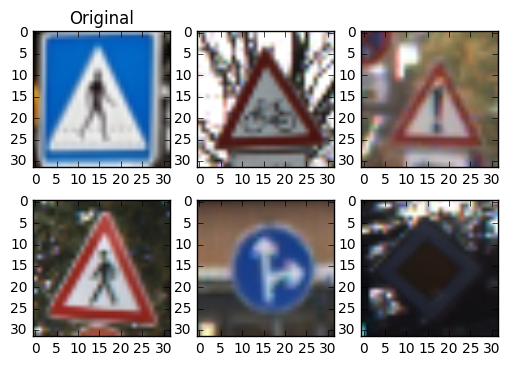

In [39]:
image_index = 3
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

ax1.imshow(image_list_ori[image_index])
ax1.set_title('Original')

image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][0]])
ax2.imshow(X_train2[image_1,:,:,:])
image_2 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][1]])
ax3.imshow(X_train2[image_2,:,:,:])
image_3 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][2]])
ax4.imshow(X_train2[image_3,:,:,:])
image_4 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][3]])
ax5.imshow(X_train2[image_4,:,:,:])
image_5 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][4]])
ax6.imshow(X_train2[image_5,:,:,:])

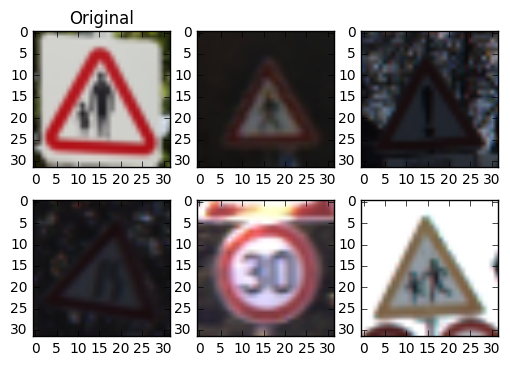

In [40]:
image_index = 4
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

ax1.imshow(image_list_ori[image_index])
ax1.set_title('Original')

image_1 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][0]])
ax2.imshow(X_train2[image_1,:,:,:])
image_2 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][1]])
ax3.imshow(X_train2[image_2,:,:,:])
image_3 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][2]])
ax4.imshow(X_train2[image_3,:,:,:])
image_4 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][3]])
ax5.imshow(X_train2[image_4,:,:,:])
image_5 = random.choice([i for i in range(len(y_train2)) if y_train2[i] == top_5[1][image_index][4]])
ax6.imshow(X_train2[image_5,:,:,:])

**Answer:**

Use the model's softmax probabilities to visualize the certainty of its predictions, tf.nn.top_k could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)

For the 1st image, the category already predicted correctly. For the 2nd image, the correct prediction appeared in the top 5. For the rest of the images, the category is not available in the training dataset.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.